# Clasificación de imágenes con Red Neuronal

## Imports

In [5]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Red neuronal de dos capas

A two-layer fully-connected neural network. The net has an input dimension of
N, a hidden layer dimension of H, and performs classification over C classes.
We train the network with a softmax loss function and L2 regularization on the
weight matrices. The network uses a ReLU nonlinearity after the first fully
connected layer.

In other words, the network has the following architecture:

input - fully connected layer - ReLU - fully connected layer - softmax

The outputs of the second fully-connected layer are the scores for each class.

In [6]:
class TwoLayerNet(object):

  def __init__(self, input_size, hidden_size, output_size, std=1e-4):
    self.params = {}
    self.params['W1'] = std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

  def loss(self, X, y=None, reg=0.0):
    # Unpack variables from the params dictionary
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    N, D = X.shape

    # Compute the forward pass
    scores = None

    XW1 = np.dot(X, W1)
    XW1pb1 = XW1 + b1
    H1 = np.maximum(XW1pb1, 0)

    H1W2 = np.dot(H1, W2)
    scores = H1W2 + b2

    if y is None:
      return scores

    # Compute the loss
    loss = None
    scores -=  np.max(scores)
    q = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)
    loss = np.sum(-np.log(q[np.arange(N), y])) / N + 0.5 * reg * (np.sum(W1 * W1) + np.sum(W2 * W2))

    # Backward pass: compute gradients
    grads = {}    
    dscores = q
    dscores[range(N), y] -= 1
    dscores /= N
    
    # scores = H1W2 + b2
    dH1W2 = dscores
    db2 = np.sum(dscores, axis=0)
    # H1W2 = np.dot(H1, W2)
    dH1 = dH1W2.dot(W2.T)
    dW2 = H1.T.dot(dH1W2)
    # H1 = np.maximum(0, XW1pb1)
    dXW1pb1 = dH1
    dXW1pb1[XW1pb1 < 0] = 0
    # XW1pb1 = XW1 + b1
    dXW1 = dXW1pb1
    db1 = np.sum(dXW1pb1, axis=0)
    # XW1 = np.dot(X, W1)
    dW1 = X.T.dot(dXW1)

    grads['W1'] = dW1 + reg * W1
    grads['b1'] = db1
    grads['W2'] = dW2 + reg * W2
    grads['b2'] = db2
    
    return loss, grads

  def train(self, X, y, X_val, y_val,
            learning_rate=1e-3, learning_rate_decay=0.95,
            reg=1e-5, num_iters=100,
            batch_size=200, verbose=False):

    num_train = X.shape[0]
    iterations_per_epoch = max(num_train / batch_size, 1)

    # Use SGD to optimize the parameters in self.model
    loss_history = []
    train_acc_history = []
    val_acc_history = []

    for it in range(num_iters):
      X_batch = None
      y_batch = None

      idxs = np.random.choice(num_train, batch_size)
      X_batch = X[idxs, :]
      y_batch = y[idxs]

      # Compute loss and gradients using the current minibatch
      loss, grads = self.loss(X_batch, y=y_batch, reg=reg)
      loss_history.append(loss)

      self.params['W1'] = self.params['W1'] - learning_rate * grads['W1']
      self.params['b1'] = self.params['b1'] - learning_rate * grads['b1']
      self.params['W2'] = self.params['W2'] - learning_rate * grads['W2']
      self.params['b2'] = self.params['b2'] - learning_rate * grads['b2']

      if verbose and it % 100 == 0:
        print('iteration %d / %d: loss %f' % (it, num_iters, loss))

      # Every epoch, check train and val accuracy and decay learning rate.
      if it % iterations_per_epoch == 0:
        # Check accuracy
        train_acc = (self.predict(X_batch) == y_batch).mean()
        val_acc = (self.predict(X_val) == y_val).mean()
        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        # Decay learning rate
        learning_rate *= learning_rate_decay

    return {
      'loss_history': loss_history,
      'train_acc_history': train_acc_history,
      'val_acc_history': val_acc_history,
    }

  def predict(self, X):
    y_pred = None
    W1, b1 = self.params['W1'], self.params['b1']
    W2, b2 = self.params['W2'], self.params['b2']
    scores = np.dot(np.maximum(0, np.dot(X, W1) + b1), W2) + b2
    y_pred = np.argmax(scores, axis=1)

    return y_pred

## Cargamos los datos

In [8]:
from data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):

    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar10'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


## Train a network

To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [9]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1000: loss 2.302980
iteration 100 / 1000: loss 2.302628
iteration 200 / 1000: loss 2.298023
iteration 300 / 1000: loss 2.266841
iteration 400 / 1000: loss 2.215562
iteration 500 / 1000: loss 2.116212
iteration 600 / 1000: loss 2.006427
iteration 700 / 1000: loss 2.021554
iteration 800 / 1000: loss 1.964309
iteration 900 / 1000: loss 2.030871
Validation accuracy:  0.276


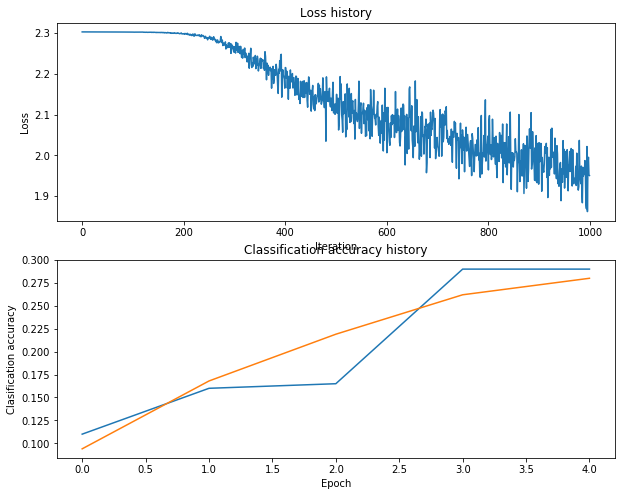

In [10]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Clasification accuracy')
plt.show()

In [13]:
hidden_size = 1000
n_iters = 1500
lr = 1e-3
r = 0.7

# Create the network
best_net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = best_net.train(X_train, y_train, X_val, y_val,
            num_iters=n_iters, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.95,
            reg=r, verbose=True)

# Predict on the validation set
val_acc = (best_net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 0 / 1500: loss 2.313317
iteration 100 / 1500: loss 1.897412
iteration 200 / 1500: loss 1.829598
iteration 300 / 1500: loss 1.782025
iteration 400 / 1500: loss 1.671955
iteration 500 / 1500: loss 1.498170
iteration 600 / 1500: loss 1.498086
iteration 700 / 1500: loss 1.601353
iteration 800 / 1500: loss 1.525132
iteration 900 / 1500: loss 1.400058
iteration 1000 / 1500: loss 1.551619
iteration 1100 / 1500: loss 1.432284
iteration 1200 / 1500: loss 1.480738
iteration 1300 / 1500: loss 1.421498
iteration 1400 / 1500: loss 1.428399
Validation accuracy:  0.506


In [14]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.514


## ¡FIN!